In [93]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

width, height = 10, 6
res = 8

field_shape =[int(height*res), int(width*res)]

charges= [
    {
        "q":1.0, 
        "p":np.array([-4,0]),
        "v":np.array([0,0]),
    },
    {
        "q":-1.0, 
        "p":np.array([0,0]),
        "v":np.array([0,0]),
    },
    {
        "q":1.0, 
        "p":np.array([4,0]),
        "v":np.array([0,0]),
    },
]
num_charges = len(charges)

x,y = np.meshgrid(
    np.linspace(-width/2, width/2, int(width*res)),
    np.linspace(-height/2, height/2, int(height*res)),    
)
u = np.zeros(field_shape)
v = np.zeros(field_shape)
# w = np.zeros(field_shape)

In [90]:

def calc_e_field(x, y, index):
    c = charges[index]
    a = c["p"]
    q = c["q"]
    
    b_p = np.array([x,y])   
    a_p = np.array([np.full(x.shape,a[0]), np.full(x.shape,a[1])])
    dir = b_p-a_p
    mag_squared = dir[0]**2 + dir[1]**2
    mag = np.sqrt(mag_squared)

    f = q/mag_squared
    f_vec = f * dir/mag

    return f_vec[0], f_vec[1]

def normalise(x,y):
    mag = np.sqrt(x**2 + y**2)
    return x/mag, y/mag, mag

def sigmoid(m):
    return 1/(1+np.power(np.e, -m))

def plot(x,y,u,v,m):
    ax = plt.figure().add_subplot()
    # ax.view_init(30, 30)
    # ax.quiver(x,y,u,v,colors=colors,length=0.25,normalize=True,pivot="middle")
    ax.quiver(x,y,u,v, sigmoid(m))
    return ax

def move_charges(delta_time):
    for c in charges:
        c["p"] += c["v"] * delta_time

def apply_electric_force(delta_time):
    c_indices = range(len(charges))
    for c_index in c_indices:
        c = charges[c_index]
        for cur_index in c_indices:
            if c_index == cur_index:
                continue
            cur_c = charges[cur_index]
            dir = cur_c["p"] - c["p"]
            mag_squared = np.dot(dir, dir)
            mag = np.sqrt(mag_squared)

            f = (c["q"]*cur_c["q"])/mag_squared

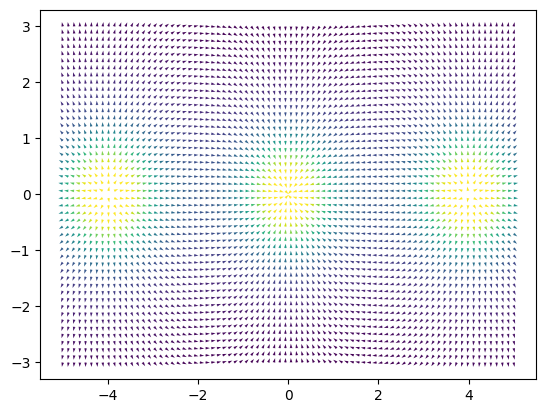

In [92]:
for i in range(len(charges)):    
    temp_u, temp_v = calc_e_field(x,y,i)
    u+=temp_u
    v+=temp_v    

u,v,m = normalise(u,v)
ax = plot(x,y,u,v,m)
# plt.savefig('charts/e_field.png', format='png', dpi=1500)

# # rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.1)

IndexError: index 1 is out of bounds for axis 0 with size 0